In [1]:
import os
import numpy as np
import pandas as pd
import cv2 as cv
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from PIL import Image

In [2]:
def fix_layout(width:int=95):
    from IPython.core.display import display, HTML
    display(HTML('<style>.container { width:' + str(width) + '% !important; }</style>'))

fix_layout()

In [3]:
# reminder: image is downscaled by 3, we need to downscale the label coordinates as well
scale = 3

### Select Dataset

In [5]:
DATASET_NUMBER = 1

In [6]:
# location of silicon wafer 1 data
dir_images = "data"+str(DATASET_NUMBER)+"_cropped/"

In [7]:
index = pd.MultiIndex.from_tuples([('point_1', 'x'), ('point_1', 'y'), ('point_2', 'x'), ('point_2', 'y'),
                                   ('point_3', 'x'), ('point_3', 'y'), ('point_4', 'x'), ('point_4', 'y')])

### Drawing

In [8]:
def rgb(hex_color):
    return tuple(int(hex_color.lstrip('#')[i:i+2], 16) for i in (0, 2 ,4))

In [9]:
def draw_labels(image, labels_df, thickness, color, fill_poly):
    for row in range(labels_df.shape[0]):
        pts = np.array(labels_df.loc[row]).reshape((-1,1,2))
        if fill_poly:
            image = cv.fillPoly(image, np.int32([pts]), color=rgb(color))
        else:
            image = cv.polylines(image, np.int32([pts]), True, color=rgb(color), thickness=thickness)
    
    return image

In [10]:
thickness = 5
magnet_color = "#00cccc"
tissue_color = "#ff6666"

fill_poly = False

In [11]:
legend_elements = [Line2D([0], [0], color=magnet_color, lw=thickness, label='Magnet Part'),
                       Line2D([0], [0], color=tissue_color, lw=thickness, label='Brain Part')]

### Plot the Segmentation boxes in cropped images

In [12]:
boxes_tissues = pd.read_csv(f"boxes_tissues_"+str(DATASET_NUMBER)+".txt", sep="\t|,", header=None, names=index, engine='python')
#Without scale
boxes_tissues.head()

point_1      point_2     point_3     point_4    
        x    y       x   y       x   y       x   y
0      36  110      16  58     142  16     148  67
1      40  114      16  64     141  16     150  65
2      38  110      16  59     143  16     149  66
3      45  126      16  78     132  16     147  66
4      44  123      16  75     136  16     148  65

In [13]:
boxes_mag = pd.read_csv(f"boxes_mag_"+str(DATASET_NUMBER)+".txt", sep="\t|,", header=None, names=index, engine='python')
#Without scale
boxes_mag.head()

point_1      point_2      point_3     point_4     
        x    y       x    y       x   y       x    y
0      55  156      37  112     148  68     156  118
1      61  160      42  117     149  67     160  114
2      58  156      39  111     150  67     158  115
3      71  171      46  128     146  66     163  113
4      68  166      44  124     148  66     162  113

In [14]:
# Draw only one box
def draw_labels_custom(image, labels_df, thickness, color, fill_poly):
    pts = np.array(labels_df).reshape((-1,1,2))
    if fill_poly:
        image = cv.fillPoly(image, np.int32([pts]), color=rgb(color))
    else:
        image = cv.polylines(image, np.int32([pts]), True, color=rgb(color), thickness=thickness)

    return image

##### Load cropped image

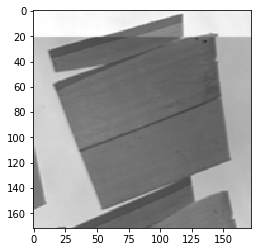

In [81]:
index_cropped_image = 0

path_cropped = "data"+str(DATASET_NUMBER)+"_cropped/"+str(index_cropped_image)+".tiff"
if os.path.isfile(path_cropped):
    cropped = cv.imread(path_cropped)
else:
    print ("The file " + path_cropped + " does not exist.")

plt.imshow(cropped)

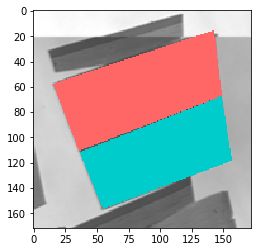

In [82]:
seg_tissue = boxes_tissues[index_cropped_image:index_cropped_image+1]
seg_mag = boxes_mag[index_cropped_image:index_cropped_image+1]

cropped = draw_labels_custom(cropped, seg_tissue, 2, tissue_color, True)
cropped = draw_labels_custom(cropped, seg_mag, 2, magnet_color, True)

plt.imshow(cropped)

In [83]:
def check_color(img_pixel):
    magnet_color = [0,204,204]
    tissue_color = [255,102,102]
    if( (img_pixel[0] == magnet_color[0]) and (img_pixel[1] == magnet_color[1]) and (img_pixel[2] == magnet_color[2]) ):
        return 'magnet'
    elif( (img_pixel[0] == tissue_color[0]) and (img_pixel[1] == tissue_color[1]) and (img_pixel[2] == tissue_color[2]) ):
        return 'tissue'
    else:
        return 'none'

In [84]:
height = cropped.shape[0]
width = cropped.shape[1]
for i in range(height):
    for j in range(width):
        if( (check_color(cropped[i,j]) != 'magnet') & (check_color(cropped[i,j]) != 'tissue') ):
            cropped[i,j] = 0

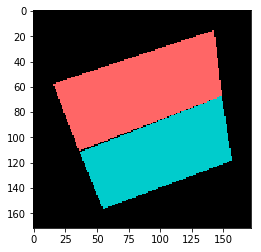

In [85]:
plt.imshow(cropped)

In [86]:
index_cropped_image = 0

path_mask_both = "data"+str(DATASET_NUMBER)+"_cropped/mask_both/"+str(index_cropped_image)+".tiff"
cv.imwrite(path_mask_both, cropped)

True

In [87]:
def generate_mask(image, class_type):
    height = image.shape[0]
    width = image.shape[1]
    
    # Size of the image
    img_mask = np.zeros([height,width],dtype=np.uint8)
    img_mask.fill(0)
    
    for i in range(height):
        for j in range(width):
            if( (check_color(image[i,j]) != class_type)):
                img_mask[i,j] = 0
            else:
                img_mask[i,j] = 255
    
    return img_mask

In [88]:
mag_mask = generate_mask(cropped, 'magnet')

True

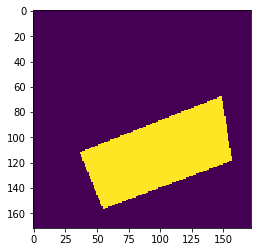

In [89]:
plt.imshow(mag_mask)

path_mask_both = "data"+str(DATASET_NUMBER)+"_cropped/mask_mag/"+str(index_cropped_image)+".tiff"
cv.imwrite(path_mask_both, mag_mask)

In [90]:
tissue_mask = generate_mask(cropped, 'tissue')

True

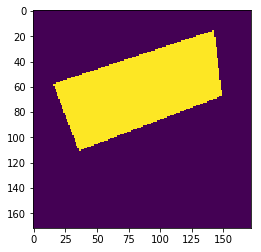

In [91]:
plt.imshow(tissue_mask)

path_mask_both = "data"+str(DATASET_NUMBER)+"_cropped/mask_tissue/"+str(index_cropped_image)+".tiff"
cv.imwrite(path_mask_both, tissue_mask)

### Create masks image for the complete dataset

In [92]:
for index_image in range(boxes_mag.shape[0]):
    

    path_cropped = "data"+str(DATASET_NUMBER)+"_cropped/"+str(index_image)+".tiff"
    if os.path.isfile(path_cropped):
        cropped = cv.imread(path_cropped)
    else:
        print ("The file " + path_cropped + " does not exist.")

    seg_tissue = boxes_tissues[index_image:index_image+1]
    seg_mag = boxes_mag[index_image:index_image+1]

    cropped = draw_labels_custom(cropped, seg_tissue, 2, tissue_color, True)
    cropped = draw_labels_custom(cropped, seg_mag, 2, magnet_color, True)
    
    height = cropped.shape[0]
    width = cropped.shape[1]
    for i in range(height):
        for j in range(width):
            if( (check_color(cropped[i,j]) != 'magnet') & (check_color(cropped[i,j]) != 'tissue') ):
                cropped[i,j] = 0
    
    path_mask_both = "data"+str(DATASET_NUMBER)+"_cropped/mask_both/"+str(index_image)+".tiff"
    cv.imwrite(path_mask_both, cropped)
    
    mag_mask = generate_mask(cropped, 'magnet')
    path_mask_both = "data"+str(DATASET_NUMBER)+"_cropped/mask_mag/"+str(index_image)+".tiff"
    cv.imwrite(path_mask_both, mag_mask)
    
    tissue_mask = generate_mask(cropped, 'tissue')
    path_mask_both = "data"+str(DATASET_NUMBER)+"_cropped/mask_tissue/"+str(index_image)+".tiff"
    cv.imwrite(path_mask_both, tissue_mask)

